In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def gen_splited_train_data(sizes, means, covs):
    np.random.seed(0)
    pos_x = np.random.multivariate_normal(means[1], covs[1], sizes[1])
    pos_y = np.array([1] * sizes[1])
    neg_x = np.random.multivariate_normal(means[0], covs[0], sizes[0])
    neg_y = np.array([0] * sizes[0])
    train_x = np.append(pos_x, neg_x, axis=0)
    train_y = np.append(pos_y, neg_y, axis=0)
    return train_x, train_y


def evaluate(pred_y, true_y):
    tn, fp, fn, tp = confusion_matrix(true_y, pred_y).ravel()
    precision = tp / float(tp + fp)
    recall = tp / float(tp + fn)
    return tp, tn, fp, fn, precision, recall


def pred_area(clf, xmax, ymax, grid_size=0.05, thr=0):
    xx, yy = np.meshgrid(np.arange(-xmax, xmax, grid_size),
                               np.arange(-ymax, ymax, grid_size))
    Z = (clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) >= thr
                                     ).astype(np.int).reshape(xx.shape)
    return xx, yy, Z

    
def draw_roc(features, labels, clf, thresholds):
    if 0 not in thresholds:
        print('0 not included in thresholds')
    data = []
    thr0 = []
    for thr in thresholds:
        decisions = clf.decision_function(features)
        pred_y = (decisions >= thr).astype(np.int)
        _, _, _, _, precision, recall = evaluate(pred_y, labels)
        values = [thr, recall, precision]
        if thr == 0:
            thr0.append(values)
        else:
            data.append(values)
    total = data + thr0
    df = pd.DataFrame(total, columns=['threshold', 'recall', 'precision']
                            ).sort_values(by='threshold')
    plt.plot(df['recall'], df['precision'], marker="o", c="k")
    plt.plot(thr0[0][1], thr0[0][2], marker="o",  c="r")
    for thr, recall, precision in df.dropna().values:
        plt.annotate(thr, xy=(recall - 0.075, precision - 0.08), size=10)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.grid()
    plt.show()
    return df


def draw_contours(clf, xmax, ymax, thresholds, test_x, test_y, cm, grid_size=0.05):
    nrows = len(thresholds) // 4
    remainder = len(thresholds) % 4
    nrows = nrows + 1 if remainder !=0 else nrows
    fig, ax = plt.subplots(nrows, 4, figsize=(5 * 4, nrows * 4), sharex=True, sharey=True)
    for i, thr in enumerate(thresholds):
        row = i // 4
        col = i % 4
        xx, yy, Z = pred_area(clf, xmax, ymax, thr=thr)
        ax[row][col].contourf(xx, yy, Z, alpha=0.1, cmap=plt.cm.cool)
        ax[row][col].set_title('threshold: {}'.format(thr))
        ax[row][col].scatter(test_x[:, 0], test_x[:, 1], c=test_y, cmap=cm)
    plt.xlim((-xmax, xmax))
    plt.ylim((-ymax, ymax))
    plt.show()


def case_splited(sizes, means, covs):
    # training data
    train_x, train_y = gen_splited_train_data(sizes, means, covs)

    # test data
    test_size = 100
    test_x = np.random.multivariate_normal([0, 0], [[2, 0], [0, 2]], test_size)
    test_y = (test_x[:, 0] <= 0).astype(np.int)

    # learning
    clf = SVC()
    clf.fit(train_x, train_y)

    # evaluation
    pred_y = clf.predict(test_x)
    tp, tn, fp, fn, pre, rec = evaluate(pred_y, test_y)
    print('tp: {}, tn: {}, fp: {}, fn: {}'.format(tp, tn, fp, fn))
    print('precision: {}, recall: {}'.format(pre, rec))

    # visualization
    colors = ['blue', 'red']
    cm = matplotlib.colors.ListedColormap(colors)
    xmax = np.ceil(np.max([train_x.max(), test_x.max()]))
    ymax = xmax

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    ax[0].scatter(train_x[:, 0], train_x[:, 1], c=train_y, cmap=cm)
    ax[1].scatter(test_x[:, 0], test_x[:, 1], c=test_y, cmap=cm)
    ax[2].scatter(test_x[:, 0], test_x[:, 1], c=pred_y, cmap=cm)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    xx, yy, Z = pred_area(clf, xmax, ymax)
    ax[2].contourf(xx, yy, Z, alpha=0.1, cmap=plt.cm.cool)
    plt.xlim((-xmax, xmax))
    plt.ylim((-ymax, ymax))
    plt.show()

    thresholds = [-1.5 +  0.3 * i for i in range(11)]
    df = draw_roc(test_x, test_y, clf, thresholds)
    print(df)
    draw_contours(clf, xmax, ymax, thresholds, test_x, test_y, cm)
    
    plt.savefig('pos{}_neg{}.png'.format(sizes[1], sizes[0]))

### 1. 正例、負例が明確に分離している例

tp: 48, tn: 41, fp: 0, fn: 11
precision: 1.0, recall: 0.813559322034


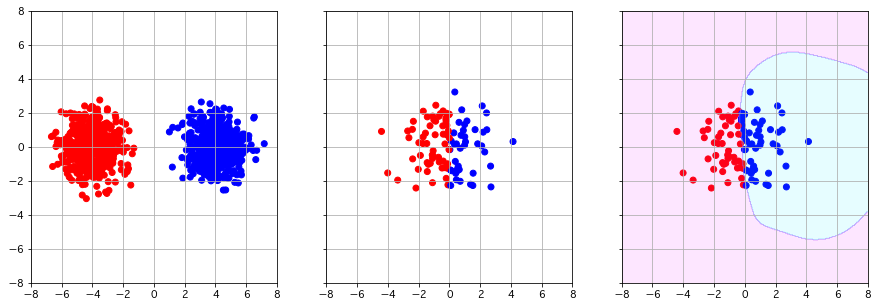

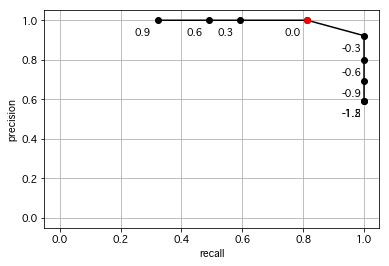

    threshold    recall  precision
0        -1.5  1.000000   0.590000
1        -1.2  1.000000   0.590000
2        -0.9  1.000000   0.694118
3        -0.6  1.000000   0.797297
4        -0.3  1.000000   0.921875
10        0.0  0.813559   1.000000
5         0.3  0.593220   1.000000
6         0.6  0.491525   1.000000
7         0.9  0.322034   1.000000
8         1.2  0.000000        NaN
9         1.5  0.000000        NaN


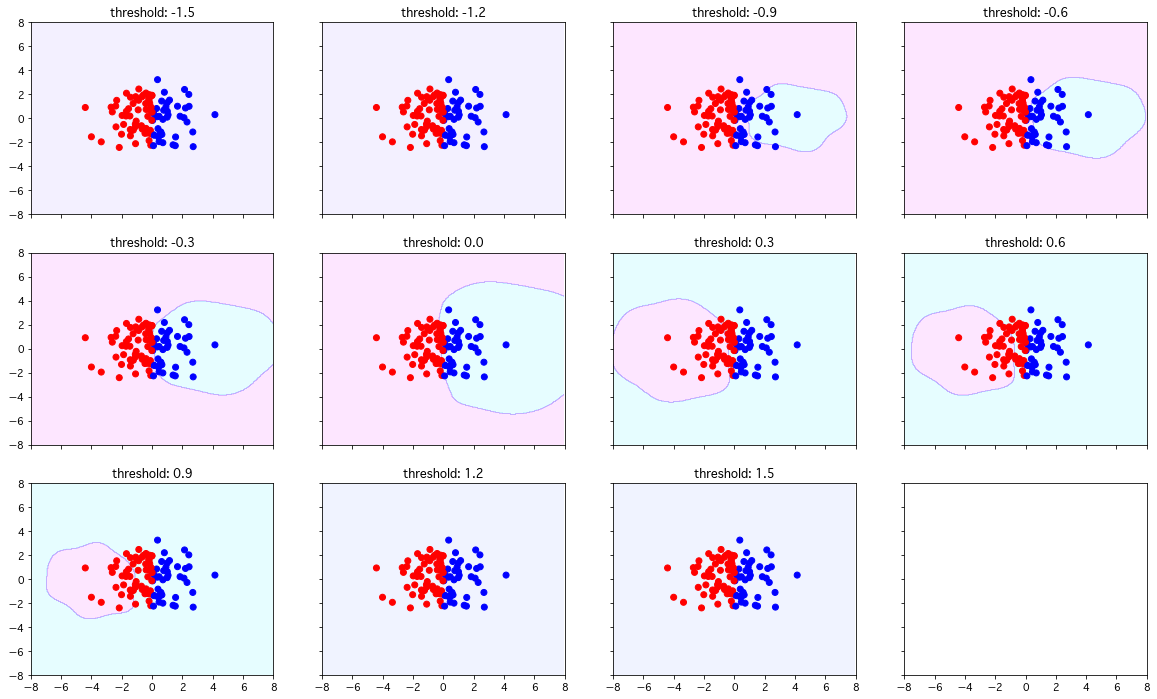

In [3]:
# training data
sizes = [500, 500]
means = [[4, 0], [-4, 0]]
covs = [[[1, 0], [0, 1]], [[1, 0], [0, 1]]]
case_splited(sizes, means, covs)

### 2. 正例、負例が完全に分離しているものの、正例過多の場合

tp: 40, tn: 38, fp: 22, fn: 0
precision: 0.645161290323, recall: 1.0


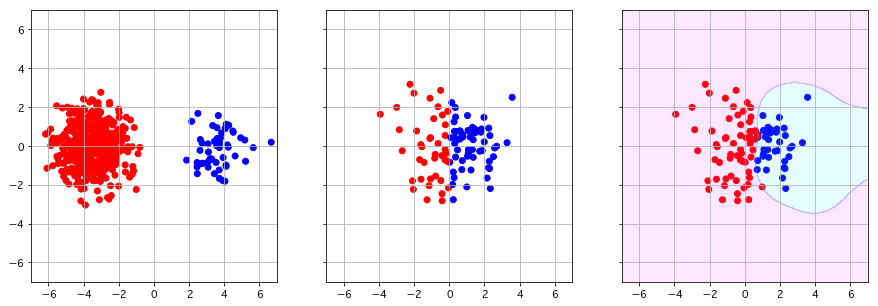

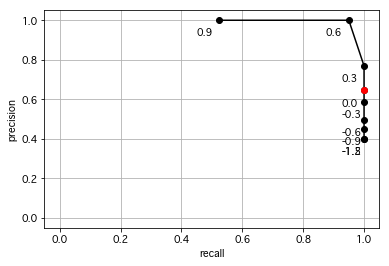

    threshold  recall  precision
0        -1.5   1.000   0.400000
1        -1.2   1.000   0.400000
2        -0.9   1.000   0.449438
3        -0.6   1.000   0.493827
4        -0.3   1.000   0.588235
10        0.0   1.000   0.645161
5         0.3   1.000   0.769231
6         0.6   0.950   1.000000
7         0.9   0.525   1.000000
8         1.2   0.000        NaN
9         1.5   0.000        NaN


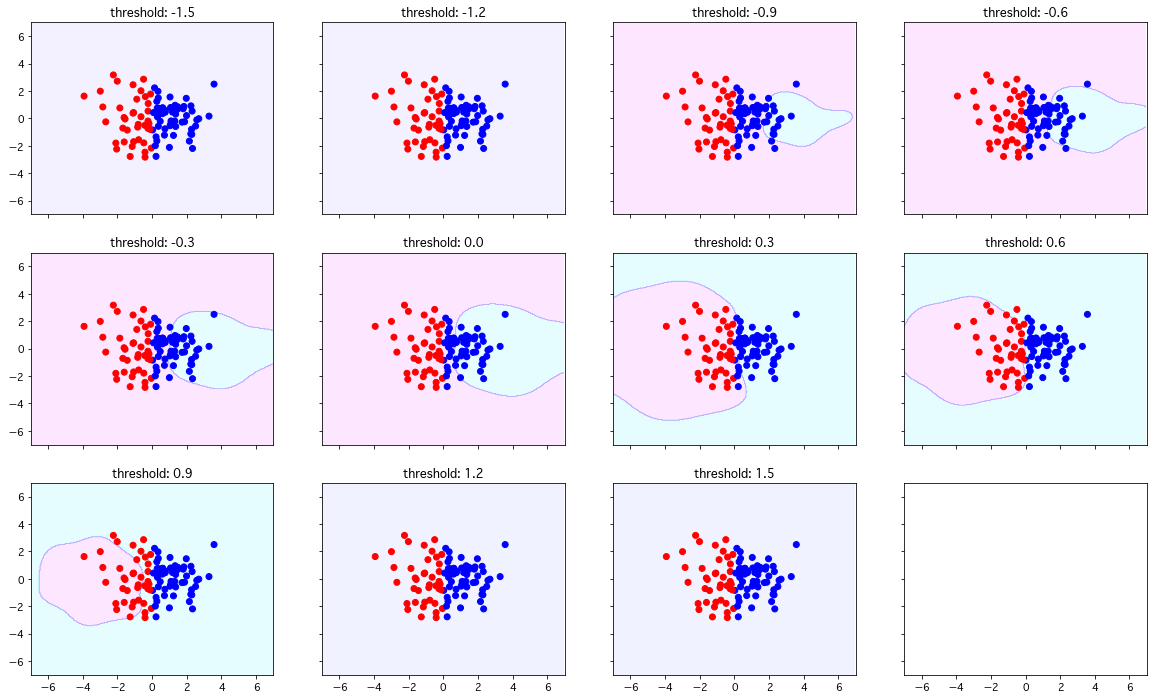

In [4]:
# training data
sizes = [50, 500]
means = [[3.5, 0], [-3.5, 0]]
covs = [[[1, 0], [0, 1]], [[1, 0], [0, 1]]]
case_splited(sizes, means, covs)

### 3. 正例、負例が完全に分離しているものの、負例過多の場合

tp: 30, tn: 60, fp: 0, fn: 10
precision: 1.0, recall: 0.75


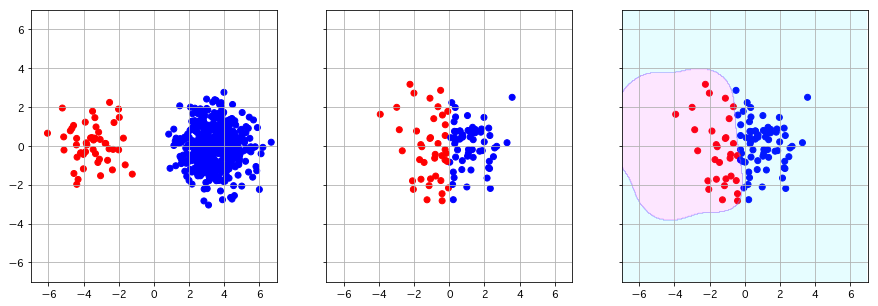

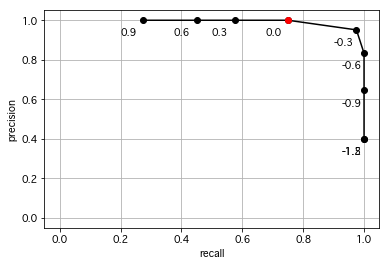

    threshold  recall  precision
0        -1.5   1.000   0.400000
1        -1.2   1.000   0.400000
2        -0.9   1.000   0.645161
3        -0.6   1.000   0.833333
4        -0.3   0.975   0.951220
10        0.0   0.750   1.000000
5         0.3   0.575   1.000000
6         0.6   0.450   1.000000
7         0.9   0.275   1.000000
8         1.2   0.000        NaN
9         1.5   0.000        NaN


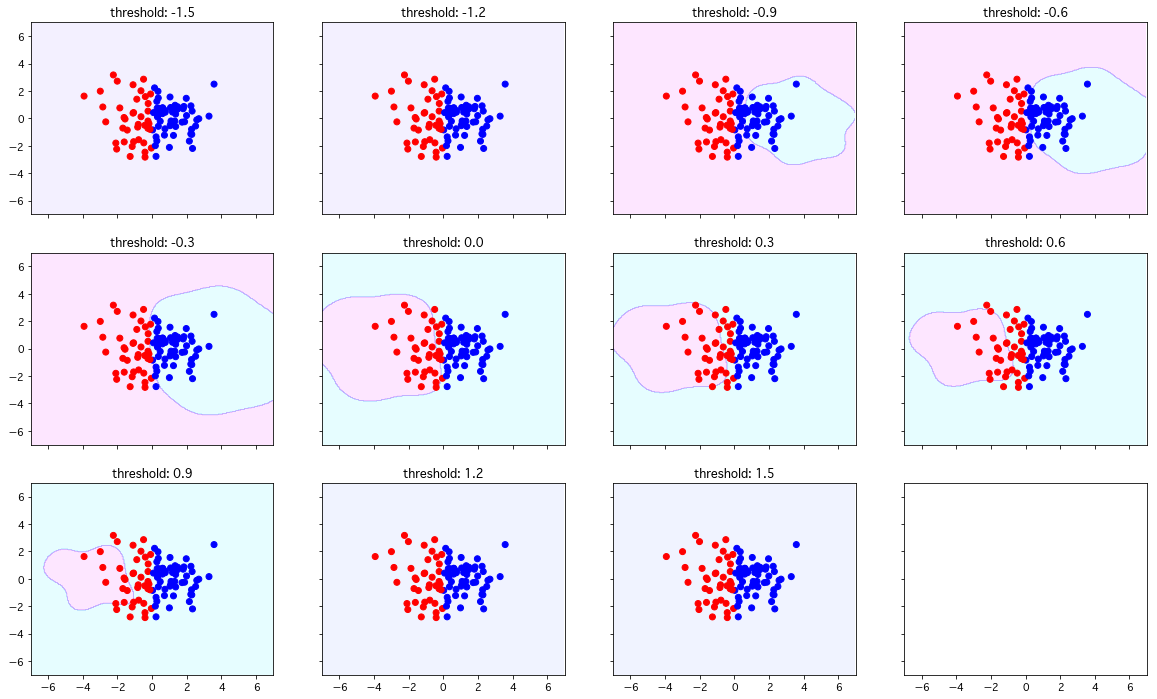

In [5]:
# training data
sizes = [500, 50]
means = [[3.5, 0], [-3.5, 0]]
covs = [[[1, 0], [0, 1]], [[1, 0], [0, 1]]]
case_splited(sizes, means, covs)